<img src="https://www.luxonis.com/logo.svg" width="400">

# Conversion of PyTorch Model

## 🌟 Overview
In this tutorial, we'll go through converting a pre-trained PyTorch model. We'll first download the model, test its inference, and export it to ONNX format. We'll then make it ready for deployment on a Luxonis device and finally test it on a device.

## 📜 Table of Contents
- [🛠️ Installation](#installation)
- [🗃️ Model Download](#model-download)
- [✍ Model Test (Optional)](#model-test)
- [📦 NN Archive](#nn-archive)
- [🗂️ Export and Archive](#export-and-archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)
- [🗂️ Export without Archive (Optional)](#onnx-export)

<a name="installation"></a>

## 🛠️ Installation

The main focus of this tutorial is using [`ModelConverter`](https://github.com/luxonis/modelconverter) for conversion of a pre-trained model [`ResNet-18`](https://pytorch.org/vision/stable/models/generated/torchvision.models.quantization.resnet18.html#resnet18) from `torchvision` to formats supported by Luxonis devices. `ModelConverter` is our open-source tool that supports conversion to all RVC Compiled Formats. Furthermore, we'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with functionality to generate a [`NN Archive`](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/). Finally, we will use [`DepthAI v3`](https://rvc4.docs.luxonis.com/software/) and [`DepthaAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/) to run the converted model, process and visualize the results. So, let's not wait any longer and get straight to it!

In [ ]:
%pip install -q --force-reinstall -U torchvision torch onnx pillow opencv-python luxonis_ml==0.6.1 depthai-nodes@git+https://github.com/luxonis/depthai-nodes.git@main modelconv@git+https://github.com/luxonis/modelconverter.git@main
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a13

<a name="model-download"></a>

## 🗃️ Model Download

First, let's download the model from `torchvision`.

In [1]:
import torchvision

# Load the pretrained ResNet-18 model
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<a name="model-test"></a>

## ✍ Model Test (Optional)

It's a good practice to verify the performance of a source model that we want to convert to know that the model is working. This way, when the model is exported and isn't performing well on a device, we know that the problem must lie in the conversion process. 

We will test the inference of the model on an image of a cat from a public dataset called [`crawford/cat-dataset`](https://www.kaggle.com/datasets/crawford/cat-dataset) available on Kaggle.

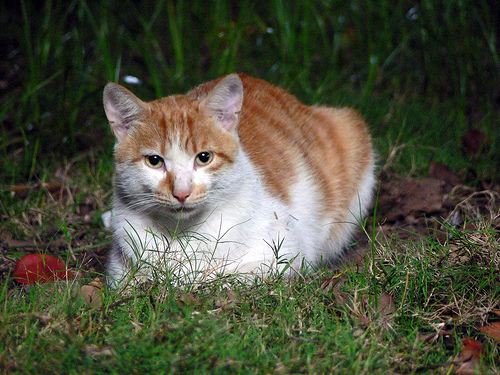

In [2]:
import IPython

img_file = "media/cat.jpg"

# Show the image
IPython.display.Image(img_file)

In [3]:
import json
from PIL import Image
import torch

#  Load the image
image = Image.open(img_file).convert("RGB")
# Define the transformation                                      
transforms = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms(antialias=True)

# Preprocess the image
input_tensor = transforms(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the top-5 predictions
_, indices = torch.topk(probabilities, 5)

# Load the labels
# Downloaded from: https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
with open('media/imagenet-simple-labels.json', 'r') as f:
    labels = json.load(f)

print("Top-5 predictions:")
for i, idx in enumerate(indices, start=1):
    print(f"{i}) {labels[idx]}: {probabilities[idx].item()*100:.2f}%")

Top-5 predictions:
1) tiger cat: 66.76%
2) tabby cat: 15.32%
3) lynx: 8.52%
4) Egyptian Mau: 4.93%
5) Persian cat: 0.60%


We have verified that the model returns reasonable predictions, so let's jump into the conversion.

<a name="nn-archive"></a>

## 📦 NN Archive

This section will introduce [`NN Archive`](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/), what it is, and its benefit. `NN Archive` is our own format that packages the model executable(s) and configuration files into a .tar.xz archive. The primary purpose of the `NN Archive` is to describe and specify what the model expects as an input, what the model outputs, and lastly, if and how to process the result. The benefit of the `NN Archive` is seamless integration with our library ecosystem, especially the `DepthAI Nodes` package responsible for processing a model's output. Later in this tutorial, we will experience the benefit of this ourselves.

We will use functions from [`LuxonisML`](https://github.com/luxonis/luxonis-ml) to create the `NN Archive`. The `NN Archive` consists of two parts, model executables (e.g. `ONNX`, `OpenVINO IR`, `TFLite`) and a config encoding the scheme version and a dictionary describing a model's inputs, outputs, heads, and metadata sections. Let's briefly describe each section.

**Inputs**

This section describes all of the model's input(s) and their preprocessing. It's defined as a list of dictionaries. To check out all its fields, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Inputs).

**Outputs**

This section specifies all the model's output(s). It's defined as a list of dictionaries containing the name and data type of the output data. For more information, refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Outputs).

**Head**

This section configures the post-processing steps applied to the model's output(s). It's again defined as a list of dictionaries. Please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Heads) to learn more about it.

**Metadata**

This section specifies the name of the model, the path to it, and the model's precision.


The creation of a `NN Archive` looks like this:

```python
from luxonis_ml.nn_archive.archive_generator import ArchiveGenerator
from luxonis_ml.nn_archive.config import CONFIG_VERSION


config = {
    "config_version": CONFIG_VERSION,       # Draw config version from luxonis-ml
    "model": {
        "metadata": { ... },                # Specify the model's metadata
        "inputs":   [ { ... }, ... ],       # Specify the model's input stream(s)
        "outputs":  [ { ... }, ... ],       # Specify the model's output stream(s)
        "heads":    [ { ... }, ... ],       # Specify all heads for the model
 }
}

generator = ArchiveGenerator(
    archive_name="...",                     # Name of the generated archive file
    save_path="...",                        # Path to the 
    cfg_dict=config,
    executables_paths=["..."]
)

generator.make_archive()                    # Archive file is saved to the specified save_path
```

<a name="export-and-archive"></a>

## 🗂️ Export and Archive

Once we are satisfied with the model's performance, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model trained with PyTorch to a more general format called [`Open Neural Network Exchange (ONNX)`](https://onnx.ai/). Then, we want to package this exported model into a `NN Archive` as described in the section above.

Let's start by exporting the model to ONNX.

In [4]:
import torch

onnx_model_path = "resnet18.onnx"
input_tensor = torch.randn(1, 3, 224, 224)  # Random input tensor

torch.onnx.export(
    model,                      # Model we want to export
    input_tensor,               # Example input tensor
    onnx_model_path,            # Path to save the ONNX model
    input_names=["images"],     # Input tensor names
    output_names=["output"],    # Output tensor names
    opset_version=11            # ONNX opset version
)

The code below creates the `NN Archive`.

In [5]:
from luxonis_ml.nn_archive import ArchiveGenerator
from luxonis_ml.nn_archive.config_building_blocks import (
    DataType,
    InputType,
)
from luxonis_ml.nn_archive.config import CONFIG_VERSION

# Define the configuration dictionary
config = {
    "config_version": CONFIG_VERSION, # draw config version from luxonis-ml
    "model": {
        "metadata": {
            "name": "resnet18",
            "path": "resnet18.onnx",
            "precision": DataType.FLOAT32
        },
        "inputs": [ # Specify all inputs to the model
            {
                "name": "images",  # Define the input tensor name
                "dtype": DataType.FLOAT32, # Define the input tensor data type
                "input_type": InputType.IMAGE, 
                "shape": [1, 3, 224, 224], # Define the input tensor shape
                "layout": "NCHW", # Define the input tensor order
                "preprocessing": {
                    "mean": [123.675, 116.28, 103.53], # Mean values for each channel applied during preprocessing
                    "scale": [58.395, 57.12, 57.375] # Scale values for each channel applied during preprocessing
                }
            }
        ],
        "outputs": [  # Specify all outputs from the model
            {
                "name": "output", # Define the output tensor name
                "dtype": DataType.FLOAT32, # Define the output tensor data type
                "shape": [1, 1000] # Define the output tensor shape
            }
        ],
        "heads": [ # Specify all heads for the model
            {
                "parser": "ClassificationParser", # Define the parser to use from depthai-nodes
                "metadata": {
                    "postprocessor_path": None,
                    "is_softmax": False, # Whether the model output is softmaxed
                    "n_classes": 1000, # Number of classes in the model
                    "classes": labels # List of class labels
                },
                "outputs": ["output"] # Define the output tensor to use for the head
            }
        ]
    }
}

archive = ArchiveGenerator(
    archive_name="resnet18", # Define string name of the generated archive.
    save_path="./", # Define string path to where you want to save the archive file.
    cfg_dict=config,
    executables_paths=["resnet18.onnx"], # Define a list of string paths to relevant model executables.
)
archive.make_archive()

'./resnet18.tar.xz'

<a name="deploy"></a>

## 🤖 Deploy

Now that we have successfully exported and archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. 


In [ ]:
!modelconverter hub login

To convert the model, we can use either CLI or Python API. We'll show both options but use the latter. For more details, please look [here](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage).

The call below will create a new model card inside your team on `HubAI` with the model file and details uploaded. It will further convert the model on the cloud to the selected target platform (e.g. [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)) and download the converted model to your device. Choosing the target is as simple as setting a `target` argument in the `convert` function or using: 

- `modelconverter hub convert rvc2 ...` or
- `modelconverter hub convert rvc4 ...`.

Besides this, there are some platform-specific parameters. To check them out, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/offline/modelconverter/#ModelConverter-Parameters-Platform-Specific).

In [7]:
from modelconverter import convert

# =============================================================================
# RVC2 conversion
# =============================================================================
converted_model = convert(
    "rvc2",
    path="resnet18.tar.xz",
    name="Resnet18",
    description_short="Pretrained Resnet18 on ImageNet",
    tasks=["CLASSIFICATION"],
    license_type="MIT",
    is_public=False
)

# Equivalent command using the CLI
# !modelconverter hub convert rvc2 --path "resnet18.tar.xz" \
#                                 --name "Resnet18" \
#                                 --description-short "Pretrained Resnet18 on ImageNet" \
#                                 --tasks "CLASSIFICATION" \
#                                 --license-type "MIT" \
#                                 --no-is-public

# =============================================================================
# RVC4 conversion
# =============================================================================
# converted_model = convert(
#     "rvc4", 
#     path="resnet18.tar.xz",
#     name="Resnet18",
#     description_short="Pretrained Resnet18 on ImageNet",
#     tasks=["CLASSIFICATION"],
#     license_type="MIT",
#     quantization_data="general",
#     is_public=False
# )

# Equivalent command using the CLI
# !modelconverter hub convert rvc4s --path "resnet18.tar.xz" \
#                                 --name "Resnet18" \
#                                 --description-short "Pretrained Resnet18 on ImageNet" \
#                                 --tasks "classification" \
#                                 --license-type "MIT" \
#                                 --quantization-data "GENERAL" \
#                                 --no-is-public

WARNING  /Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/albumentation ]8;id=264757;file:///Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=377699;file:///Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         s/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have              
         1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks,                
         set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.                                               
           check_for_updates()                                                                                     
                                                                                                                   

Model variant 'Resnet18 224x224' created with ID 'b742485f-d647-4706-8253-89b052d27b0d'

Model instance 'Resnet18 224x224 base instance' created with ID 'f4a3820d-45ff-401f-8c7c-ead494145770'

File 'resnet18.tar.xz' uploaded to model instance 'f4a3820d-45ff-401f-8c7c-ead494145770'

Model instance 'Resnet18 224x224 exported to rvc2' created for rvc2 export with ID 
'dbe0c990-5cc6-41b9-b31e-3716afe3c181'

Output()

Donwloaded 'resnet18-224x224-exported-to-rvc2/resnet18.rvc2.tar.xz'

We can see for ourselves that this call really created a new model card on `HubAI` with the exported model.

<img src="./media/resnet_model_exported.png" alt="Exported model on HubAI" width="800">

We have successfully converted our model for RVC2 and RVC4 devices, so let's test it on the camera! Please copy the path to the downloaded archive with the converted model from the output log of the appropriate code cell; we will use it in the next section.

In [10]:
MODEL_PATH = "resnet18-224x224-exported-to-rvc2/resnet18.rvc2.tar.xz"

To check out other possible ways to convert your model for our devices, please refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/).

<a name="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we need to have `DepthAI v3` and `Depthai Nodes` installed. Moreover, the following script must be run locally and requires a Luxonis device connected to your machine.

Here is the script to run the model on the DepthAI device:

In [ ]:
import cv2
import depthai as dai
from depthai_nodes import Classifications
from depthai_nodes.node import ParsingNeuralNetwork
import numpy as np


def visualize_classification(frame: np.ndarray, message: Classifications) -> bool:
    """Visualizes the classification on the frame."""
    classes = message.classes[:2]
    scores = message.scores[:2]
    if frame.shape[0] < 128:
        frame = cv2.resize(frame, (frame.shape[1] * 2, frame.shape[0] * 2))
    for i, (cls, score) in enumerate(zip(classes, scores)):
        cv2.putText(
            frame,
            f"{cls}: {score:.2f}",
            (10, 20 + 20 * i),
            cv2.FONT_HERSHEY_TRIPLEX,
            0.5,
            255,
        )

    cv2.imshow("Classification", frame)
    if cv2.waitKey(1) == ord("q"):
        cv2.destroyAllWindows()
        return True

    return False

device = dai.Device()
platform = device.getPlatform()

img_frame_type = dai.ImgFrame.Type.BGR888i if platform.name == "RVC4" else dai.ImgFrame.Type.BGR888p

with dai.Pipeline(device) as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_archive = dai.NNArchive(MODEL_PATH)
    # Create the neural network node
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((224, 224), type=img_frame_type, fps=30), 
        nn_archive
    )
    # Create output queues
    parser_output_queue = nn_with_parser.out.createOutputQueue()
    frame_queue = nn_with_parser.passthrough.createOutputQueue()

    # Start pipeline
    pipeline.start()

    while pipeline.isRunning():
        # Get the frame
        frame: dai.ImgFrame = frame_queue.get().getCvFrame()
        # Get the parsed message containing the segmentation mask
        parser_msg: dai.ImgFrame = parser_output_queue.get()
        if visualize_classification(frame, parser_msg):
            pipeline.stop()
            break

<a name="onnx-export"></a>

## 🗂️ Export without Archive (Optional)

It is also possible to skip the model archiving and convert the model straight from `ONNX.` However, when running the model on the device, we'd need to define parsers and other parameters manually, so we recommend first creating the `NN Archive` and then converting the model.

In [ ]:
from modelconverter import convert

converted_model = convert(
    "rvc2", 
    path="resnet18.onnx",
    name="Resnet18 ONNX",
    description_short="Pretrained Resnet18 on ImageNet",
    tasks=["CLASSIFICATION"],
    license_type="MIT",
    is_public=False
)

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed a pre-trained ResNet18 classification model to our cameras!